# Project for exam *Applied Machine Learning - Basic*

**Daniele Massaro**, PhD student in Physics (36° cycle)  
*Alma Mater Studiorum - Università di Bologna*

---

# The MNIST project
The [MNIST](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology database) is a database of handwritten digits, widely used by the machine learning community to evaluate the capabilities of their algorithms.

> If it doesn't work on MNIST, it won't work at all.  
> Well, if it does work on MNIST, it may still fail on others.

>   -- *Unknown author*


It was developed by Yann LeCun, Corinna Cortes and Christopher Burges.  
The MNIST database contains 60000 training images and 10000 testing images, which were taken from various scanned documents.
They have been normalised to fit 28x28 pixel bounding box and centered.

Excellent results achieve a prediction error of less than 1%.
State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks.

## Prepare the environment and load the dataset

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import pandas as pd
import seaborn as sns
import sklearn
from joblib import dump, load

##### matplotlib settings
from matplotlib.pyplot import rcParams, rcParamsDefault

##### pandas settings
from pandas import set_option

set_option('display.width', 200)
set_option('display.max_rows', 100)
set_option('display.max_columns', 50)
set_option('precision', 3)

##### numpy settings
from numpy import set_printoptions

set_printoptions(precision=3, linewidth=400)

##### pseudo-random number generator seed
seed = 7

The database is made of four different datasets:
* [`train-images-idx3-ubyte.gz`](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz):  training set images (9912422 bytes);
* [`train-labels-idx1-ubyte.gz`](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz):  training set labels (28881 bytes);
* [`t10k-images-idx3-ubyte.gz`](http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz):  test set images (1648877 bytes);
* [`t10k-labels-idx1-ubyte.gz`](http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz):  test set labels (4542 bytes).

The dataset is in binary format.
There exist a ready-to-use `.csv` version, made by Joseph Redmon and available [here](https://pjreddie.com/projects/mnist-in-csv/):
* [`mnist_train.csv`](https://pjreddie.com/media/files/mnist_train.csv);
* [`mnist_test.csv`](https://pjreddie.com/media/files/mnist_test.csv).

Each row consists of 785 values: the first one is the label (an integer from 0 to 9) and the others are the grey-scaled pixels of a 28x28 image (integers ranging from 0 to 255).

In [2]:
dataset_train = pd.read_csv(filepath_or_buffer="mnist_train.csv", sep=",", names=None, header=None)
dataset_test = pd.read_csv(filepath_or_buffer="mnist_test.csv", sep=",", names=None, header=None)
DIM_X, DIM_Y = 28, 28

## Explore dataset 1 - Numbers

In [3]:
dataset_train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Study the shape and types

In [4]:
ds_train_shape = dataset_train.shape
ds_test_shape = dataset_test.shape
print("Training dataset shape:", ds_train_shape)
print("Test dataset shape:", ds_test_shape)

Training dataset shape: (60000, 785)
Test dataset shape: (10000, 785)


In [5]:
dataset_test.dtypes

0      int64
1      int64
2      int64
3      int64
4      int64
       ...  
780    int64
781    int64
782    int64
783    int64
784    int64
Length: 785, dtype: object

### See if there are corrupted values

In [6]:
print("Corrupted values:")
print("In training dataset: {}".format(np.sum(~np.isfinite(dataset_train.values))))
print("In test dataset: {}".format(np.sum(~np.isfinite(dataset_test.values))))

Corrupted values:
In training dataset: 0
In test dataset: 0


### See if we are in a case of skewed classes
Let's see if the dataset is homogeneous, namely we have about the same quantities of samples from each class.
In this case we group the datasets by the first index (the label) and we count how many of them appears.
As a cross check, the sum of the sizez should be equal to the number of the rows of the dataset.

In [7]:
sizes_train = dataset_train.groupby(by=0).size()
print(sizes_train)
print("Average number of samples from each class: {:.2f} {:s} {:.2f}".format(sizes_train.mean(), u"\u00B1", sizes_train.std()))
print("Sum of sizes:", sizes_train.sum())

0
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64
Average number of samples from each class: 6000.00 ± 339.51
Sum of sizes: 60000


In [8]:
sizes_test = dataset_test.groupby(by=0).size()
print(sizes_test)
print("Average number of samples from each class: {:.2f} {:s} {:.2f}".format(sizes_test.mean(), u"\u00B1", sizes_test.std()))
print("Sum of sizes:", sizes_test.sum())

0
0     980
1    1135
2    1032
3    1010
4     982
5     892
6     958
7    1028
8     974
9    1009
dtype: int64
Average number of samples from each class: 1000.00 ± 62.40
Sum of sizes: 10000


For both training and test datasets we have that the samples from each class are about the same (within a couple of standard deviation at most).  
We can consider the dataset to be homogeneous, so, in the following, the accuracy score will represent a robust performance measure.

Let's draw some of these digits.

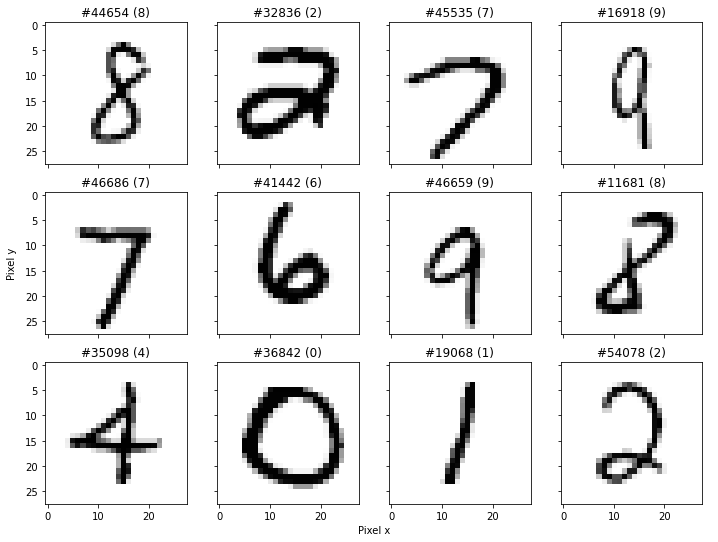

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(30/2.54,22.5/2.54))
axs[0,0].set_aspect("equal", share=True)
digits_indices = random.randint(0, ds_train_shape[0], size=axs.size, dtype=np.int)
for ax, i in zip(axs.flatten(), digits_indices):
    label = dataset_train.values[i,0]
    pixels = dataset_train.values[i,1:].reshape((DIM_X, DIM_Y))
    ax.set_title("#{:d} ({:d})".format(i, label))
    ax.imshow(pixels, cmap="Greys")
# Draw a big invisible axes to insert common axis labels
big_ax = fig.add_subplot(111, frameon=False)
big_ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
big_ax.set_xlabel("Pixel x")
big_ax.set_ylabel("Pixel y");

## Explore dataset 2 - Visualisation
We can plot the distribution of the labels and see if they follow an uniform distribution.

In [10]:
def plot_hist_labels(dataset, title):
    fig, ax = plt.subplots()
    dataset_train[0].hist(ax=ax, bins=np.arange(-0.5, 10., 1))
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(np.arange(10))
    ax.set_xlabel("Label")
    ax.set_ylabel("Counts")
    ax.set_title(title)
    return fig, ax

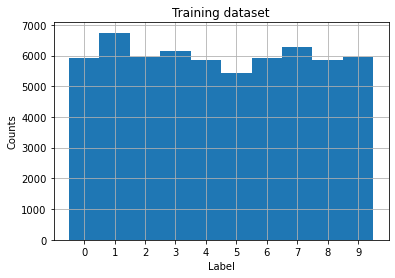

In [11]:
plot_hist_labels(dataset_train, title="Training dataset");

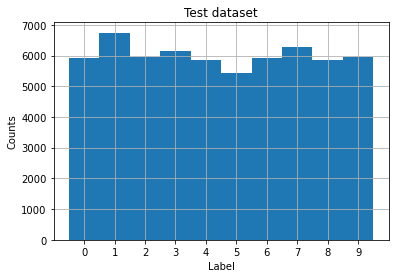

In [12]:
plot_hist_labels(dataset_train, title="Test dataset");

## Data preparation
We separate the datasets in `x` and `y`.
We normalise the `x` values in range $[0,1]$.
This is simple, as now the range is $[0,255]$.

In [13]:
x_train = dataset_train.values[:,1:] / 255.
y_train = dataset_train.values[:,0]
x_test = dataset_test.values[:,1:] / 255.
y_test = dataset_test.values[:,0]

## Resampling
We will use a $10$-fold cross validation to split up the training dataset.

In [14]:
from sklearn.model_selection import KFold
num_folds = 10

## Model comparison
This problem is an example of multiclass classification.
The classes are the integer numbers from 0 to 9.
Each hand-written digit is associated to one of them.  
In principle, I would need to wrap the classifier inside [`sklearn.multiclass.OneVsRestClassifier`](https://scikit-learn.org/stable/modules/multiclass.html#onevsrestclassifier), but the following models already support multiclass classification:
* Logistic Regression (LR);
* Linear Discriminant Analysis (LDA);
* $k$-Nearest Neighbors (KNN);
* Classification and Regression Trees (CART);
* Naive Bayes (NB);
* Support Vector Machines (SVM).

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [16]:
models = []
models.append(('LR'  , LogisticRegression(solver='lbfgs', max_iter=500)))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB'  , GaussianNB()))
models.append(('SVM' , SVC(probability=True)))

I will compute the following scores, assuming a one-vs-rest test:
* accuracy (`'accuracy'`);
* weighted Area Under ROC Curve (AUC, `'roc_auc_ovr_weighted'`);
* weighted F1-score (`'f1_weighted'`).

I will also plot the different confusion matrices for each model.

In [17]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

```{warning}
The following cell may require a while to execute.  
I provide the file `performance_metrics_1_model_comparison.npz` containing the different arrays of observables computed by the following cell.
```

In [18]:
names = []
accuracies = []
aucs = []
f1_scores = []
confusion_matrices = []
for name, model in models:
    names.append(name)
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    accuracies.append(cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy', n_jobs=2))
    aucs.append(cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc_ovr_weighted', n_jobs=2))
    f1_scores.append(cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1_weighted', n_jobs=2))
    y_predicted = cross_val_predict(model, x_train, y_train, cv=kfold, n_jobs=2)
    confusion_matrices.append(confusion_matrix(y_train, y_predicted))
    # save the model with joblib
    dump(model, "trained_models/{}.joblib".format(name))
np.savez(
    file="performance_metrics_model_comparison",
    names=np.array(names, dtype=np.str),
    accuracies=np.array(accuracies, dtype=np.float),
    aucs=np.array(aucs, dtype=np.float),
    f1_scores=np.array(f1_scores, dtype=np.float),
    confusion_matrices=np.array(confusion_matrices, dtype=np.int)
)

KeyboardInterrupt: 

In [19]:
i = 4
names = []
accuracies = []
aucs = []
f1_scores = []
confusion_matrices = []
name, model = models[i]
names.append(name)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
accuracies.append(cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy', n_jobs=2, error_score='raise'))
aucs.append(cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc_ovr_weighted', n_jobs=2, error_score='raise'))
f1_scores.append(cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1_weighted', n_jobs=2, error_score='raise'))
y_predicted = cross_val_predict(model, x_train, y_train, cv=kfold, n_jobs=2)
confusion_matrices.append(confusion_matrix(y_train, y_predicted))
np.savez(
    file="performance_metrics_{:d}_model_comparison".format(i),
    names=np.array(names, dtype=np.str),
    accuracies=np.array(accuracies, dtype=np.float),
    aucs=np.array(aucs, dtype=np.float),
    f1_scores=np.array(f1_scores, dtype=np.float),
    confusion_matrices=np.array(confusion_matrices, dtype=np.int)
)

In [20]:
dump(model, "trained_models/{}.joblib".format(name))

['trained_models/NB.joblib']

Read the saved file.

In [ ]:
performance_metrics = np.load("performance_metrics_1_model_comparison.npz")
names               = performance_metrics['names']
accuracies          = performance_metrics['accuracies']
aucs                = performance_metrics['aucs']
f1_scores           = performance_metrics['f1_scores']
confusion_matrices  = performance_metrics['confusion_matrices']

Let's inspect the metrics.

In [ ]:
format_metric = lambda metric: "{:.5f} {:s} {:.5f}".format(metric.mean(), u"\u00B1", metric.std())
model_metrics = {
    'Accuracy': dict(zip(names, list(map(format_metric, accuracies)))),
    'Weighted AUC': dict(zip(names, list(map(format_metric, aucs)))),
    'Weighted F1-score': dict(zip(names, list(map(format_metric, f1_scores)))),
}
pd.DataFrame(model_metrics)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3*15/2.54, 13/2.54))
for ax, scoring, results in zip(axs, ['Accuracy', 'Weighted AUC', 'Weighted F1-score'], [accuracies, aucs, f1_scores]):
    ax.boxplot([*results]) # convert to a list of numpy.array
    ax.set_title(scoring)
    ax.set_xticklabels(names)

Let's draw the confusion matrices.

In [ ]:
w_cbar = 0.7 # cm
main_dimension = 15 # cm
ncols = 3
nrows = np.ceil(len(models) / 3).astype(np.int)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*main_dimension/2.54, nrows*main_dimension/2.54))
axs.flatten()[0].set_aspect("equal", share=True)
for ax in axs.flatten():
    ax.set_frame_on(False)
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# draw a big invisible axes to insert common colormap
big_ax = fig.add_subplot(111, frameon=False)
big_ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
v_min, v_max = 0, np.max(confusion_matrices)
cmap = "Blues"
scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=v_min, vmax=v_max))
# set a constant width of colorbar: modify aspect parameter on the basis of the new height of colorbar
transformation = fig.transFigure + fig.dpi_scale_trans.inverted()
h_cbar_fig = 0.6
h_cbar = transformation.transform((0., h_cbar_fig))[1]
# draw the colorbar
cbar = fig.colorbar(scalar_mappable, ax=big_ax, aspect=h_cbar*2.54/w_cbar)
cbar.ax.set_position([0.95, 0.2, 0.1, h_cbar_fig])
cbar.ax.set_ylabel("Occurrences")
# draw the confusion matrices
for ax, name, cm in zip(axs.flatten(), names, confusion_matrices): # if there are less names than axes, it is truncated automatically
    ax.set_title(name)
    sns.heatmap(cm, ax=ax, annot=True, annot_kws={'fontsize': 8}, cmap=cmap, fmt="d", vmin=v_min, vmax=v_max, cbar=False)